In [1]:
import streamlit as st
import pandas as pd
import plotly.express as px
import numpy as np
# import streamlit.components.v1 as components

In [303]:
%%writefile stream_router.py
import streamlit as st
import pandas as pd

st.set_page_config(layout="wide")
@st.cache_data
def load_data():
    st.session_state.df = pd.read_pickle('./amazon_delivery_cleaned_and_extracted_features_final_streamlit.pkl')
if 'df' not in st.session_state:
    load_data()
    st.session_state.reset_data = load_data

pg = st.navigation([st.Page("./pages/overview_page.py",
                            title="Overview",
                            icon=":material/overview:",
                            default=True
                           ),
                    st.Page("./pages/analysis_page.py",
                            title="Analysis",
                            icon=":material/analytics:",
                            default=False
                           ),
                    st.Page("./pages/map_page.py",
                            title="Map Analysis",
                            icon=":material/map:",
                            default=False
                           ),
                    st.Page("./pages/agent_page.py",
                            title="Agent Analysis",
                            icon=":material/person:",
                            default=False
                           )])
pg.run()

Overwriting stream_router.py


In [302]:
%%writefile ./pages/overview_page.py
import streamlit as st
import pandas as pd
import plotly.express as px
from st_aggrid import AgGrid



palette = [
    "#323434", "#E1BCDA", "#8A8783", "#EADE61", "#F1EBE0", "#424445",
    "#B9B4A7", "#C8D0D2", "#E5C1B1", "#A6B7B9", "#F4A8A1", "#9B9B9B", "#D6E0C4","#F9F5E5"]

with open('./animations/delivery-animate.svg', 'r') as file:
    svg_content = file.read()
st.markdown(f"<div style='width: 300px; height: 300px; align: center'>{svg_content}</div>", unsafe_allow_html=True)
st.title("Delivery Data Overview")

st.header("Summary Statistics")
st.write(st.session_state.df.describe())
st.write(st.session_state.df.select_dtypes('string').describe())

st.header("Order Count by Category")
fig = px.bar(st.session_state.df['Category'].value_counts().reset_index(), x='Category', y='count', color='Category', labels={'count': 'Number of orders'}, color_discrete_sequence=px.colors.qualitative.Pastel).update_layout(showlegend=False)
st.plotly_chart(fig)
    
st.sidebar.title("Settings")
if st.sidebar.checkbox("Show raw data"):
    st.subheader("Raw Data")
    if 'ID' not in locals():
        ID = ''
        password = ''
        edit = False
    if not edit:
        ID = st.text_input("", placeholder="Order ID", max_chars=13, autocomplete='off', value=ID)
    col1, col2 = st.columns([1,1])
    with col1:
        edit = st.checkbox("Edit raw data")
    if edit:
        st.warning("You are about to edit the raw data!")
        password = st.text_input("", placeholder="password", autocomplete='password', value = password, type='password')
        if password == '12345678':
            with col2:
                reset = st.button("Reset Data")
            if reset:
                st.session_state.df = pd.read_pickle('.amazon_delivery_cleaned_and_extracted_features_final_streamlit.pkl')
                st.success("Data reseted successfully!", icon = '✅')
            st.session_state.df = st.data_editor(st.session_state.df)
        elif password != '':
            st.error("Wrong password!")
    else:
        st.dataframe((st.session_state.df.loc[ID] if ID in st.session_state.df.index else {f"{ID}": 'not found'}) if ID != '' else st.session_state.df, hide_index=True if ID == '' else False)


Overwriting ./pages/overview_page.py


In [300]:
%%writefile ./pages/analysis_page.py
import streamlit as st
import plotly.express as px
from st_aggrid import AgGrid
with open('./animations/analysis-animate.svg', 'r') as file:
    svg_content = file.read()
st.markdown(f"<div style='width: 300px; height: 300px; align: center'>{svg_content}</div>", unsafe_allow_html=True)
st.title("Detailed Analysis")
tab1, tab2 = st.tabs(['Static Analysis', 'Dynamic Analysis'])
with tab1:
    st.header("Vehicles Along Pick-up Time")
    fig = px.line(st.session_state.df.groupby(['Pickup Time', 'Vehicle']).agg('count')['Agent Age'].rename('count').reset_index(['Vehicle']).sort_index(), y='count', color='Vehicle', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Dark24).update_layout(yaxis_title='Number of orders')
    st.plotly_chart(fig)
    
    st.header("Store Types And Delivery Categories And Drop Types")
    fig = px.treemap(st.session_state.df, path=['Store Type Of Location', 'Category', 'Drop Type Of Location'], template='plotly_dark', height=700, color_discrete_sequence=px.colors.qualitative.Bold)
    st.plotly_chart(fig)

    choice = st.radio('Location:', options=('Store', 'Drop'), index = 0, help='Choose the location of the store or drop', horizontal=True)
    st.header(f"{choice} Locations")
    fig = px.sunburst(st.session_state.df, path=[f'{choice} Country', f'{choice} State', f'{choice} City District'], template = 'plotly_dark', height=700, color_discrete_sequence=px.colors.qualitative.Dark24 if choice == 'Store' else px.colors.qualitative.Dark24_r)
    st.plotly_chart(fig)
    
with tab2:
    def fig1():
        if 'x' not in st.session_state:
            st.session_state.x = st.session_state.x_old = st.session_state.y = st.session_state.y_old = None
            st.session_state.c = st.session_state.c_old = st.session_state.s = st.session_state.s_old = None
            st.session_state.f = st.session_state.f_old = None
            st.session_state.bar = st.session_state.bar_old = 'relative'
        def histo():
            st.plotly_chart(px.histogram(data_frame=st.session_state.df.astype('string'), x=st.session_state.x, y=st.session_state.y, color=st.session_state.c, pattern_shape=st.session_state.s, histfunc=st.session_state.f, barmode=st.session_state.bar, color_discrete_sequence=px.colors.qualitative.Dark24))
            
        col1, col2, col3, col4, col5 = st.columns(5)
        
        with col1:
            st.session_state.x = st.selectbox(label='x-axis', options=[None] + list(st.session_state.df.columns[1:]), index=0, key = 11)
        with col2:
            st.session_state.y = st.selectbox(label='y-axis', options=[None] + list(st.session_state.df.columns), index=0, key = 12)
        with col3:
            st.session_state.c = st.selectbox(label='color', options=[None] + list(st.session_state.df.select_dtypes('string').columns[1:]), index=0, key = 13)
        with col4:
            st.session_state.s = st.selectbox(label='shape', options=[None] + list(st.session_state.df.select_dtypes('string').columns[1:]), index=0, key = 14)
        with col5:
            st.session_state.f = st.selectbox(label='function', options=[None , 'count', 'sum', 'avg', 'min', 'max'], index=0, key = 15)
        st.session_state.bar = st.radio('Barmode', options=('relative', 'group', 'overlay'), index = 0, horizontal = True)
        
        if st.session_state.x != st.session_state.x_old or st.session_state.y != st.session_state.y_old or st.session_state.c != st.session_state.c_old or st.session_state.s != st.session_state.s_old or st.session_state.f != st.session_state.f_old or st.session_state.bar != st.session_state.bar_old:
            if st.session_state.y is not None or st.session_state.x is not None:
                histo()
            st.session_state.x_old = st.session_state.x
            st.session_state.y_old = st.session_state.y
            st.session_state.c_old = st.session_state.c
            st.session_state.s_old = st.session_state.s
            st.session_state.bar_old = st.session_state.bar
    def fig2():
        st.header("Filter by Vehicle Type")
        vehicle_type = st.selectbox("Select Vehicle Type", st.session_state.df['Vehicle'].unique())
        filtered_data = st.session_state.df[st.session_state.df['Vehicle'] == vehicle_type]
        AgGrid(filtered_data)
    fig1()
    fig2()

Overwriting ./pages/analysis_page.py


In [41]:
%%writefile ./map_page.py
import streamlit as st
import plotly.express as px
import streamlit.components.v1 as components
import folium
from folium.plugins import MarkerCluster
from streamlit_folium import st_folium


with open('./animations/paper-map-animate.svg', 'r') as file:
    svg_content = file.read()
st.markdown(f"<div style='width: 300px; height: 300px; align: center'>{svg_content}</div>", unsafe_allow_html=True)
st.title("Maps")
tab1, tab2 = st.tabs(['Map Analysis', 'Advanceed Map Analysis'])
with tab1:
    st.header("Store Locations")
    fig = px.scatter_mapbox(st.session_state.df, lat='Store Latitude', lon='Store Longitude', color='Store City District', zoom=2, height=300)
    fig.update_layout(mapbox_style="carto-darkmatter")
    st.plotly_chart(fig)
    
    st.header("Drop Locations")
    fig = px.scatter_mapbox(st.session_state.df, lat='Drop Latitude', lon='Drop Longitude', color='Drop City District', zoom=2, height=300)
    fig.update_layout(mapbox_style="carto-darkmatter")
    st.plotly_chart(fig)
with tab2:
    @st.cache_data
    def load_kepler():
        with open('./kepler.gl.html', 'r') as file:
            html_content = file.read()
        return html_content
    components.html(load_kepler(), height=600)
    @st.cache_data
    def load_folium():
        center_lat = (st.session_state.df['Drop Latitude'].mean() + st.session_state.df['Store Latitude'].mean())/2
        center_lon = (st.session_state.df['Drop Longitude'].mean() + st.session_state.df['Store Longitude'].mean())/2
        mymap = folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles='CartoDB dark_matter')
        marker_cluster = MarkerCluster().add_to(mymap)
        def markers(row):
            folium.Marker(
                location=[row['Store Latitude'], row['Store Longitude']],
                popup=f"Lat: {row['Store Latitude']}<br>Lon: {row['Store Longitude']}",
                tooltip=f"{row['Order ID']}",
                icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
            ).add_to(marker_cluster)
            folium.Marker(
                location=[row['Drop Latitude'], row['Drop Longitude']],
                popup=f"Lat: {row['Drop Latitude']}<br>Lon: {row['Drop Longitude']}",
                tooltip=f"{row['Order ID']}",
                icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
            ).add_to(marker_cluster)

        st.session_state.df.apply(markers, axis = 1)
        return mymap
    m = load_folium()
    st_folium(m, width=700, height=500)

Overwriting ./pages/map_page.py


In [42]:
%%writefile ./pages/agent_page.py
import streamlit as st
import plotly.express as px

with open('./animations/delivery-animate2.svg', 'r') as file:
    svg_content = file.read()
st.markdown(f"<div style='width: 300px; height: 300px; align: center'>{svg_content}</div>", unsafe_allow_html=True)
st.title("Agent Performance")

st.header("Agent Rating Distribution")
fig = px.histogram(st.session_state.df.astype('string'), x=st.session_state.df['Agent Rating'].astype('string'))
st.plotly_chart(fig)

st.header("Agent Age Distribution")
fig = px.histogram(st.session_state.df.astype('string'), x='Agent Age')
st.plotly_chart(fig)

st.header("Filter by Agent Rating")
rating = st.slider("Select Rating", min_value=0.0, max_value=5.0, value=(0.0, 5.0))
filtered_data = st.session_state.df[(st.session_state.df['Agent Rating'] >= rating[0]) & (st.session_state.df['Agent Rating'] <= rating[1])]
st.write(filtered_data)

Overwriting ./pages/agent_page.py


In [ ]:
!streamlit run stream.py

In [265]:
df =  pd.read_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_final_streamlit.pkl')

In [243]:
df['Store Postcode'] = df['Store Postcode'].astype(int)

In [278]:
temp = df.groupby(['Pickup Time', 'Traffic', 'Weather', 'Vehicle']).agg('count')['Agent Age'].rename('count').reset_index(['Traffic', 'Weather', 'Vehicle'])

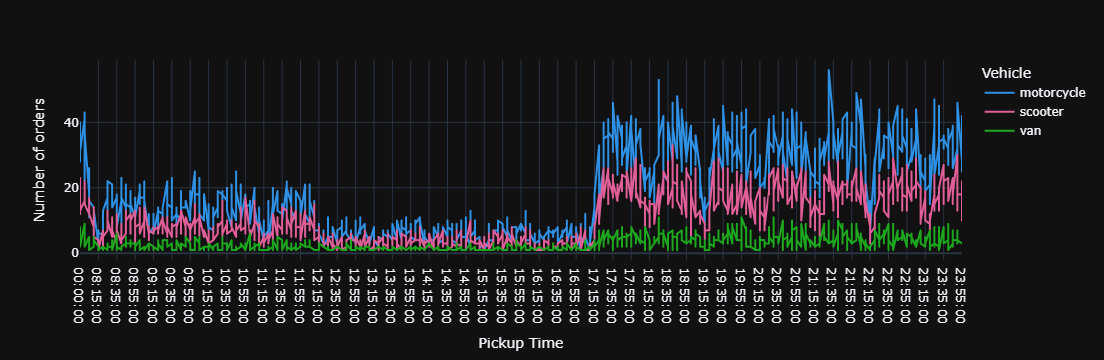

In [299]:
px.line(df.groupby(['Pickup Time', 'Traffic', 'Weather', 'Vehicle']).agg('count')['Agent Age'].rename('count').reset_index(['Traffic', 'Weather', 'Vehicle']), y='count', color='Vehicle', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Dark24).update_layout(yaxis_title='Number of orders')